# DESAFÍO N° 2 - MODELADO

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor.alphas import manual_alphas

In [47]:
data = pd.read_csv("salida_desafio_1.csv")
data.sample(5)

,Unnamed: 0,tipo_prop,barrio,pais,lat,lon,precio_usd,piso,properati_url,ambientes,...,villa_crespo,hidromasaje,san_telmo,vista,sauna,losa_radiante,capital_federal,impecable,interwin,doble_circulacion
19674,19674,apartment,Palermo,Argentina,-34.587568,-58.418054,147000.00,2.0,http://www.properati.com.ar/1ao3q_venta_depart...,1.0,...,0,0,0,0,0,0,0,0,0,0
20918,20918,apartment,Palermo,Argentina,-34.569238,-58.431610,239000.00,1.0,http://www.properati.com.ar/1as8d_venta_depart...,2.0,...,0,0,0,0,0,0,0,0,0,0
22102,22102,apartment,Caballito,Argentina,-34.622640,-58.441040,136275.00,NaN,http://www.properati.com.ar/1axb8_venta_depart...,2.0,...,0,0,0,0,0,0,0,0,0,0
32262,32262,apartment,Belgrano,Argentina,-34.562700,-58.458290,NaN,NaN,http://www.properati.com.ar/1cj0x_venta_depart...,NaN,...,0,0,0,0,0,0,0,0,1,0
11058,11058,apartment,Villa Urquiza,Argentina,-34.573371,-58.473584,361401.53,70.0,http://www.properati.com.ar/18wox_venta_depart...,4.0,...,0,0,0,0,0,0,0,0,0,0


## Reducción de volumen de datos

Decidimos elegir como dataset de trabajo los barrios dentro de la Comuna 13: Belgrano, Nuñez y Colegiales

Esta decisión la tomamos ya que es una de las comunas con mayor desarrollo inmobiliario en la CABA. Vamos a trabajar con 4122 datos de tres barrios porteños.

In [48]:
data2 = data[(data.barrio == "Palermo") | (data.barrio == "Palermo Hollywood") | (data.barrio == "Palermo Soho") | (data.barrio == "Palermo Chico") | (data.barrio == "Palermo Viejo")]
data2.shape

(4083, 57)

## Preparación del DATASET

In [49]:
data2.sample(10)
data2.columns

data2.drop(['Unnamed: 0', 'pais', 'lat', 'lon', 'precio_usd', 'villa_urquiza', 'barrio_norte', 'villa_crespo', 'lujoso', 'san_telmo',
          'capital_federal', 'impecable', 'interwin', 'properati_url', 'properati_url_clean'], axis = 1, inplace = True)

In [50]:
data2['piso'] = data2.piso.apply(lambda x: np.NaN if x > 30 else x)
data2['ambientes'] = data2.ambientes.apply(lambda x: np.NaN if x > 8 else x)
data2['sup_total'] = data2.sup_total.apply(lambda x: np.NaN if x == 0 else x)

In [51]:
a = data2[data2.tipo_prop == "apartment"].piso.fillna(int(data2.piso.mode()))
b = data2[data2.tipo_prop != "apartment"].piso.fillna(0)

piso = a.append(b)

data2['piso'] = data2.piso.fillna(piso)

data2.ambientes.fillna(int(data2.ambientes.mode()), inplace = True)

data2.isnull().sum()

data2 = data2[data2.sup_total.notnull()]

data = data2[data2.precio_x_m2_usd.notnull()]

## Modelado

#### Preparación de dummies y categoricas

In [52]:
a = pd.get_dummies(data[['tipo_prop']])
a.drop(['tipo_prop_apartment'], inplace= True, axis = 1)

data = pd.merge(data, a, left_index= True, right_index= True)

In [53]:
a = pd.get_dummies(data[['barrio']])
a.drop(['barrio_Palermo'], inplace= True, axis = 1)

data = pd.merge(data, a, left_index= True, right_index= True)

In [54]:
data.drop(['barrio', 'tipo_prop'], axis = 1, inplace= True)

In [55]:
data = data[data.precio_x_m2_usd < 12000]

## Feature Engineering

In [56]:
a = data.sup_total - data.sup_cubierta
data['sup_libre'] = a.apply(lambda x: 0 if x <= 0 else x)
data['por_sup_libre'] = data.sup_libre / data.sup_total
data['por_sup_cubierta'] = data.sup_cubierta/data.sup_total

data['ambientes'] = data.ambientes.apply(lambda x: 1 if x == 0 else x)
data['tamaño_ambiente'] = data['sup_cubierta'] / data['ambientes']


data['sup_cubierta_2'] = np.square(data.sup_cubierta)
data['sup_total_2'] = np.square(data.sup_total)
data['sup_libre_2'] = np.square(data.sup_libre)


data['comisarias_2'] = np.square(data.comisarias)


a = data.parrilla + data.piscina + data['sum'] + data.gimnasio + data.sauna
data['amenity'] = a.apply(lambda x: 1 if x > 0 else 0)


data['patio_parrilla'] = data.parrilla * (data.patio + data.jardin)
data['patio_parrilla'] = data.patio_parrilla.apply(lambda x: 1 if x >= 1 else x)
data['patio_parrilla_piscina'] = data.parrilla * data.piscina * (data.patio + data.jardin)
data['patio_parrilla_piscina'] = data.patio_parrilla_piscina.apply(lambda x: 1 if x >= 1 else x)


a = data.jardin + data.patio
data['patios'] = a.apply(lambda x: 1 if x > 0 else 0)
data['libre_abierto'] = data.sup_libre * data.patios


a = data.jardin + data.patio + data.terraza + data.balcon
data['espacio_abierto'] = a.apply(lambda x: 1 if x > 0 else 0)


data['piso_luminoso'] = data.piso.apply(lambda x: 1 if x > 5 else 0)


data['subtes_cat'] = data.subtes.apply(lambda x: 'ninguno' if x == 0 else ('uno' if x == 1 else 'dos_o_mas'))
data['bicis_cat'] = data.bicis.apply(lambda x: 'ninguna' if x == 0 else 'alguna')


a = pd.get_dummies(data[['subtes_cat', 'bicis_cat']])
a.drop(['subtes_cat_ninguno', 'bicis_cat_ninguna'], inplace= True, axis = 1)
data = pd.merge(data, a, left_index= True, right_index= True)
data.drop(['subtes_cat', 'bicis_cat'], axis = 1, inplace= True)

In [57]:
data.drop(['subte_linea_a', 'subte_linea_c', 'subte_linea_e'], axis = 1, inplace=True)

Separamos el dataset en un segmento de entrenameinto y otro de testeo

In [58]:
X = data.drop('precio_x_m2_usd', axis = 1)
y = data.precio_x_m2_usd

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 555)


Xs = data.drop('precio_x_m2_usd', axis = 1)
ys = data.precio_x_m2_usd

std = StandardScaler()

X_std = Xs[['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis', 
           'comisarias', 'sup_libre', 'por_sup_libre', 'por_sup_cubierta',
       'tamaño_ambiente', 'sup_cubierta_2', 'sup_total_2', 'sup_libre_2',
       'comisarias_2', 'libre_abierto']]

X_std = std.fit_transform(X_std)

Xs[['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis', 'comisarias', 'sup_libre', 'por_sup_libre', 'por_sup_cubierta','tamaño_ambiente', 'sup_cubierta_2', 'sup_total_2', 'sup_libre_2','comisarias_2', 'libre_abierto']] = X_std

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, shuffle = True)

In [59]:
print(X_train.shape)
print(X_test.shape)

(2618, 61)
(873, 61)


### Regresión Lineal Multiple

In [60]:
model_lrm = LinearRegression()

model_lrm.fit(X_train, y_train)
print(model_lrm.score)

y_predict = model_lrm.predict(X_test)

print("El score obtenido en el dataset de training fue de:", r2_score(y_train, model_lrm.predict(X_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(y_test, y_predict))

<bound method RegressorMixin.score of LinearRegression()>
El score obtenido en el dataset de training fue de: 0.24259240885496458
El score obtenido en el dataset de testing fue de: 0.2564743811305116


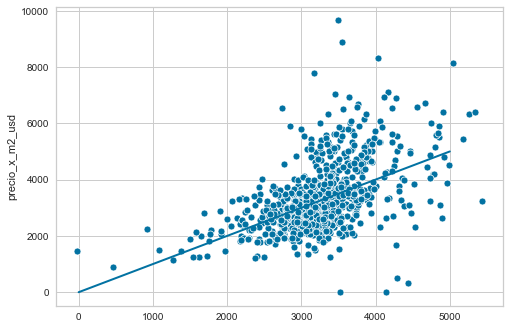

In [73]:
sns.scatterplot(y = y_test, x = y_predict)
plt.plot([0, 5000], [0, 5000], linewidth=2)
plt.show()

## WARNINGS

Importamos un metodo para evitar los print de warnings en casos donde la solución no converge

In [74]:
import warnings
warnings.filterwarnings('ignore')

## LASSO

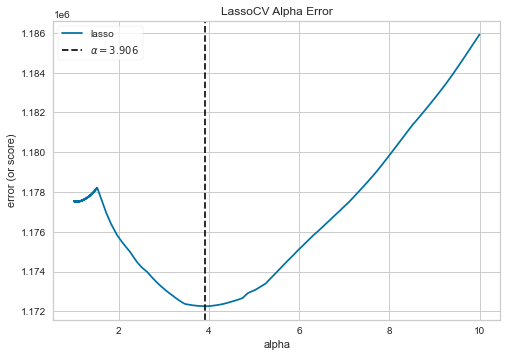

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [75]:
model_lasso = LassoCV(cv = 3, alphas = np.linspace(1,10,5000))
visualizer = AlphaSelection(model_lasso)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

In [76]:
model_lasso = LassoCV(cv = 3, alphas = np.linspace(1,15,5000))


model_lasso.fit(Xs_train, ys_train)
y_predict = model_lasso.predict(Xs_test)

print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_lasso.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))
print()
coeficientes = list(model_lasso.coef_)
nombre = list(Xs.columns)

coef = pd.DataFrame(coeficientes, index = nombre)
coef

El score obtenido en el dataset de training fue de: 0.22828175491209335
El score obtenido en el dataset de testing fue de: 0.23943919987789086



,0
piso,10.763377
ambientes,0.000000
sup_total,0.000000
sup_cubierta,275.007557
subtes,0.000000
...,...
espacio_abierto,-153.929062
piso_luminoso,-205.600189
subtes_cat_dos_o_mas,-51.590916
subtes_cat_uno,14.615288


In [86]:
coef.columns = ['a']
np.abs(coef).sort_values(ascending = True, by = 'a')[:20]

,a
jardin,0.000000
sum,0.000000
baulera,0.000000
aire_acondicionado,0.000000
dependencias,0.000000
parrilla,0.000000
hidromasaje,0.000000
subte_linea_h,0.000000
lavadero,0.000000
sup_total_2,0.000000


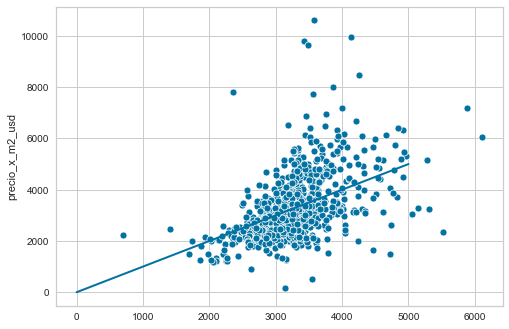

In [77]:
sns.scatterplot(y = ys_test, x = y_predict)
plt.plot([0, 5000], [0, 5000], linewidth=2)
plt.show()

## RIDGE

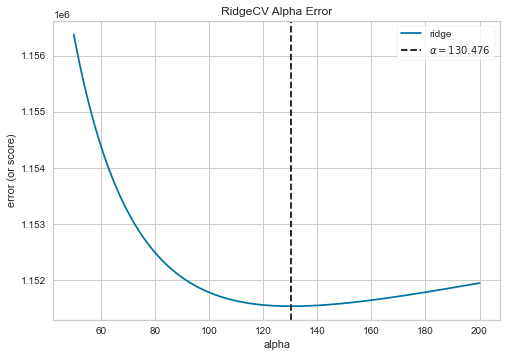

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [34]:
model_ridge = RidgeCV(alphas = np.linspace(10,60,5000))
visualizer = AlphaSelection(model_ridge)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

In [36]:
model_ridge = RidgeCV(cv = 3, alphas = np.linspace(10,60,500))


model_ridge.fit(Xs_train, ys_train)
y_predict = model_ridge.predict(Xs_test)

print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_ridge.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))
print()
coeficientes = list(model_ridge.coef_)
nombre = list(Xs.columns)

coef = pd.DataFrame(coeficientes, index = nombre)
coef

El score obtenido en el dataset de training fue de: 0.24702786667966126
El score obtenido en el dataset de testing fue de: 0.1923002814211544



## ELASTICNET

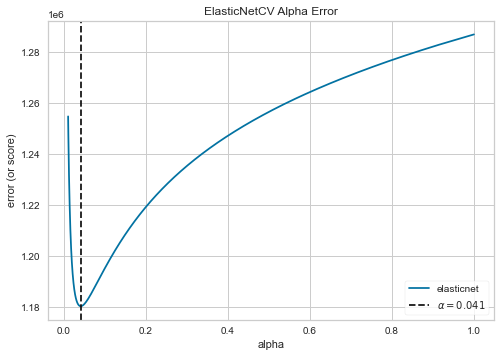

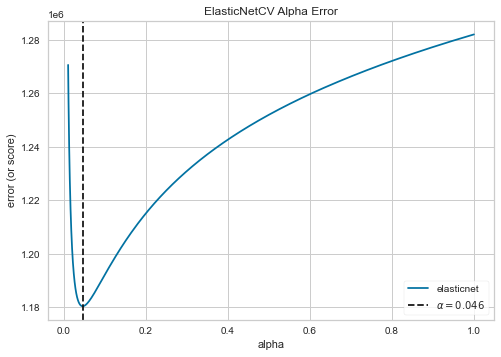

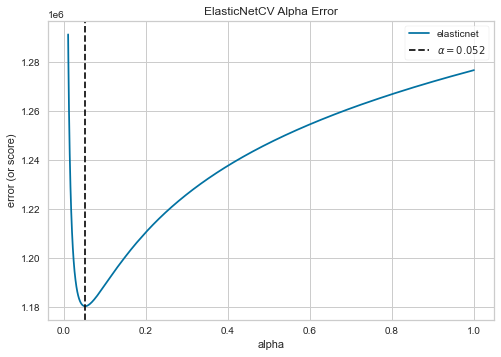

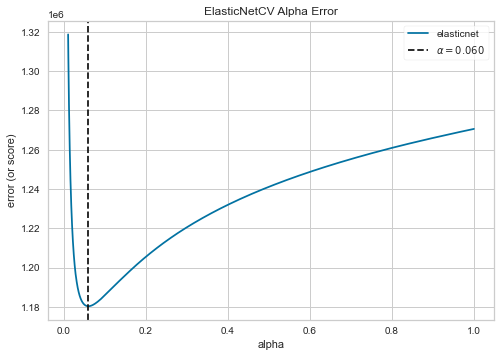

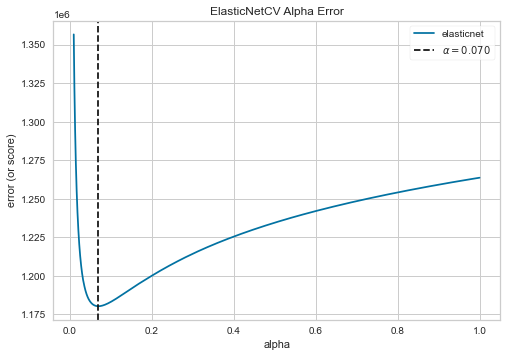

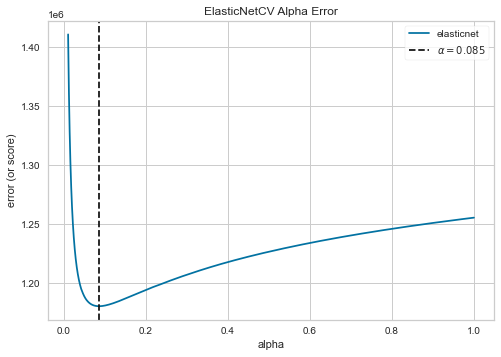

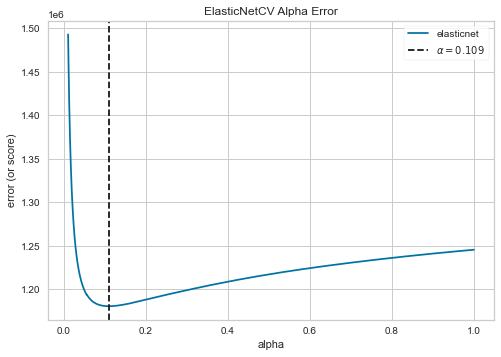

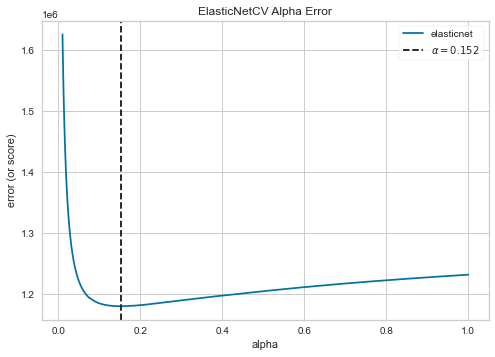

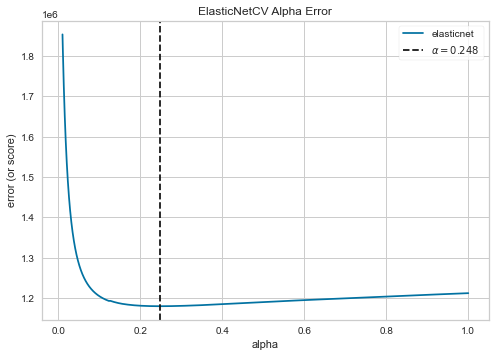

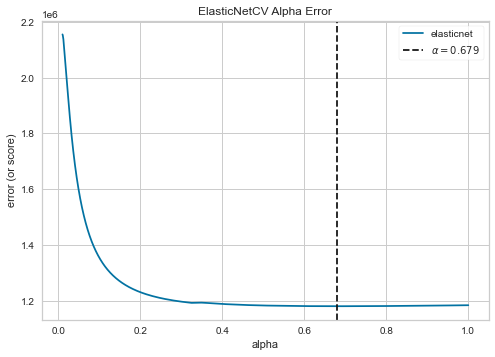

[0.22326369723346995,
 0.22326911277542127,
 0.223291676511718,
 0.22327635516398137,
 0.22327444227629367,
 0.2232917501267937,
 0.22328846971515404,
 0.22332213342711316,
 0.22334823149420013,
 0.2233015787650906]

In [155]:
metrica_r2 = []
for x in np.linspace(0.1,0.95,10):
    model_eln = ElasticNetCV(cv = 3, l1_ratio=x, alphas = np.linspace(0.01,1,5000))
    visualizer = AlphaSelection(model_eln)
    visualizer.fit(Xs_train, ys_train)
    visualizer.show()

    
    model_eln = ElasticNetCV(cv = 3, l1_ratio= visualizer.l1_ratio_, alphas = visualizer.alphas)

    model_eln.fit(Xs_train, ys_train)
    y_predict = model_eln.predict(Xs_test)
    
    metrica_r2.append(r2_score(ys_test, y_predict))

metrica_r2
#     print("El score obtenido en el dataset de training fue de:", r2_score(y_train, model_eln.predict(X_train)))
#     print("El score obtenido en el dataset de testing fue de:", r2_score(y_test, y_predict))

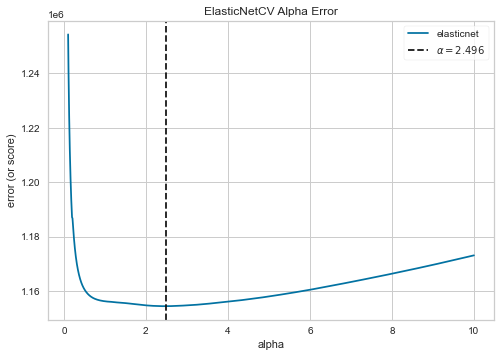

El score obtenido en el dataset de training fue de: 0.2414702628595483
El score obtenido en el dataset de testing fue de: 0.19945447580331155


In [37]:
model_eln = ElasticNetCV(cv = 3, l1_ratio=0.95, alphas = np.linspace(0.1,10,5000))
visualizer = AlphaSelection(model_eln)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

model_eln = ElasticNetCV(cv = 3, l1_ratio= visualizer.l1_ratio_, alphas = visualizer.alphas, tol = 0.01)

model_eln.fit(Xs_train, ys_train)
y_predict = model_eln.predict(Xs_test)
    
print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_eln.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))